### Pressurization of a fracure in a poroelastic medium

Fully-coupled poroelastic model

In [7]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pygmsh

from utils.MesherWrapper import Mesh
from utils.MeshUtils import MeshUtils
from utils import MatrixAssembly
from utils import PoroElasticProperties as prop

# Problem definition
## Mesh definition

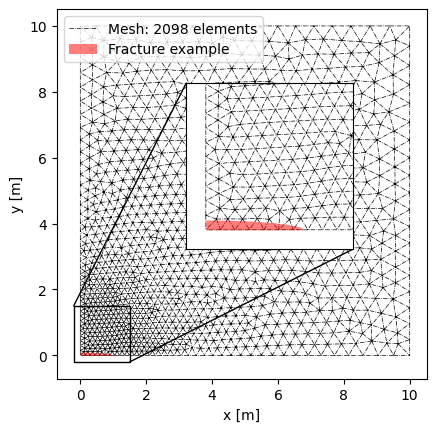

In [2]:
fracture_length = 1
height = 10
width = 10

vertices = np.array([
    [0, 0],
    [width, 0],
    [width, height],
    [0, height]
])

def cell_size(dim, tag, x, y, z, lc, pow=0.7):
    radius = np.sqrt(x**2 + y**2)/fracture_length
    return 2*fracture_length * max(1.5, radius**pow) / 20

with pygmsh.geo.Geometry() as geom:
    geom.add_polygon(vertices)
    geom.set_mesh_size_callback(cell_size, False)
    out = geom.generate_mesh()

mesh = Mesh(out, simultype='axis')
mesh = MeshUtils.tri3_to_tri6(mesh)  # Linéaire ou quadratique? # TODO

fig, ax, _ = mesh.plot(
    triplot_kw=dict(
        label=f"Mesh: {mesh.number_els} elements"
    ),
    box=True
)
axins = mesh.zoom_plot(zoom_xys=(
    (-fracture_length/5, 1.5*fracture_length),
    (-fracture_length/5, 1.5*fracture_length)
))

_x = np.linspace(0, fracture_length)
_y = fracture_length/10*np.sqrt(1-(_x/fracture_length)**2)
for axis in (ax, axins):
    axis.fill_between(_x, _y,
                      color='r', alpha=0.5,
                      zorder=4, linewidth=0,
                      label="Fracture example")
ax.legend(loc='upper left')
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
plt.show()

## Boundary conditions

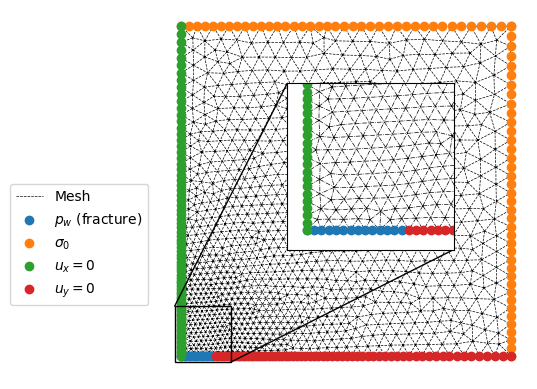

In [3]:
tol = np.sqrt(width*height/mesh.number_els)/100

top = np.argwhere(np.isclose(mesh.nodes[:, 1], height, atol=tol))[:, 0]
bottom = np.argwhere(np.isclose(mesh.nodes[:, 1], 0, atol=tol))[:, 0]
left = np.argwhere(np.isclose(mesh.nodes[:, 0], 0, atol=tol))[:, 0]
right = np.argwhere(np.isclose(mesh.nodes[:, 0], width, atol=tol))[:, 0]

boundaries = np.hstack((top, bottom, left, right))

fracture = np.argwhere(
    np.isclose(mesh.nodes[:, 1], 0, atol=tol)
    & (mesh.nodes[:, 0] <= fracture_length)
)[:, 0]  # Initial fracture width ?  # TODO

# displacements
fixed_x = left
fixed_y = np.setdiff1d(bottom, fracture)
fixed_s = np.hstack((top, right))


_, ax, _ = mesh.plot(triplot_kw=dict(ls='--', label='Mesh'), zorder=1)
axins = mesh.zoom_plot(zoom_xys=((-.2, 1.5), (-.2, 1.5)))
for axes in (ax, axins):
    axes.scatter(*mesh.nodes[fracture].T, label="$p_w$ (fracture)")
    axes.scatter(*mesh.nodes[fixed_s].T, label="$\sigma_0$")
    axes.scatter(*mesh.nodes[fixed_x].T, label="$u_x=0$")
    axes.scatter(*mesh.nodes[fixed_y].T, label="$u_y=0$")

ax.legend(loc=(-0.4, 0.2))
plt.show()

## Material properties

In [4]:
k = 8.4e3  # elastic drained bulk modulus [MPa]
g = 6.8e3  # shear modulus [MPa]
b = 0.707692  # biot coefficient
M = 9.18478e3  # biot modulus [MPa]
perm = 0.137549e-3  # permeability
mu_f = 1  # fluid viscosity
rho = 1  # density

kappa = perm / mu_f  # conductivity
k_u = prop.undrained_bulk_modulus(k, b, M)
B = (k_u-k)/(b*k_u)  # Needed ?  # TODO

nu_u = prop.poisson_ratio(g, k_u)  # undrained Poisson ratio
E_u = prop.young_modulus(g, k_u)  # undrained Young modulus
nu = prop.poisson_ratio(g, k)  # Poisson ratio
E = prop.young_modulus(g, k)  # Young modulus
eta = b*(1-2*nu_u)/(2*(1-nu_u))     # poroelastic parameter

## Matrix assembly

In [5]:
# assembling the different matrices
K = MatrixAssembly.assemble_stiffness_matrix(mesh, E, nu)
Mass = MatrixAssembly.assemble_mass_matrix(mesh, 1/M)
C = MatrixAssembly.assemble_conductivity_matrix(mesh, kappa)

# you need to complement the function below in its corresponding class MatrixAssembly
Ce = MatrixAssembly.assemble_coupling_matrix(mesh, b)

## Initial stress field

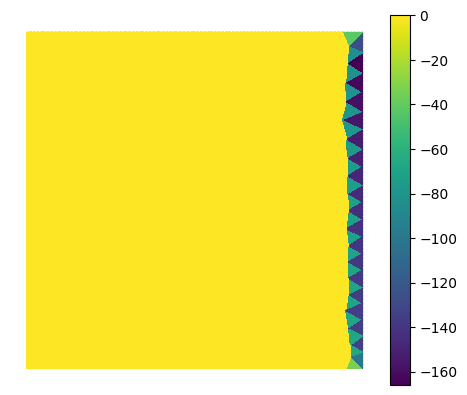

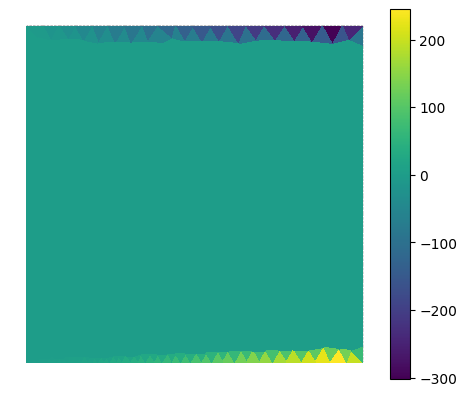

In [6]:
p0 = 30  # MPa
q0 = 10  # MPa
stress_field = - np.array([p0 - q0, p0 + q0, 0, 0])
# Not convincing... Check 'set_stress_field' in source
sigma = MatrixAssembly.set_stress_field(mesh, stress_field)

for s in sigma.reshape(2, -1, order='F'):
    _, ax, _ = mesh.plot(triplot_kw=dict(ls='--'),
                         colorvalues=s, zorder=1)
    plt.show()

### Displacement field verification

/home/axel/Documents/EPFL/CompGeo/AxelsGeoMechHW (copy)/utils/Elements.py:499: RuntimeWarning: divide by zero encountered in divide
  DNaDX = DN / j
/home/axel/Documents/EPFL/CompGeo/AxelsGeoMechHW (copy)/utils/Elements.py:499: RuntimeWarning: invalid value encountered in divide
  DNaDX = DN / j


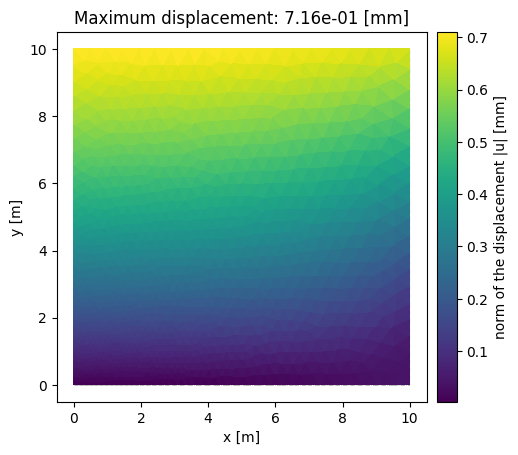

In [11]:
fx_right = np.sum(sigma[right * 2]) / height
fy_top = np.sum(sigma[top * 2 + 1]) / width
fx = MatrixAssembly.assemble_tractions_over_line(mesh, right, [fx_right, 0])
fy = MatrixAssembly.assemble_tractions_over_line(mesh, top, [0, fy_top])
f = fx + fy - sigma

dof_fixed = np.unique(np.hstack((2*left, 2 * bottom + 1)))
f_test = f + MatrixAssembly.assemble_tractions_over_line(mesh, fracture, -stress_field)
to_solve = np.setdiff1d(np.arange(2 * mesh.number_nodes), dof_fixed)

u_solved = sp.sparse.linalg.spsolve(K[to_solve][:, to_solve], f_test[to_solve])
u = np.zeros(2*mesh.number_nodes)
u[to_solve] = u_solved

fig, ax, cb = mesh.plot(
    np.linalg.norm(u.reshape(2, -1, order='F'), axis=0),
    shading='flat',
    box=True
)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
cb.ax.set_ylabel('norm of the displacement |u| [mm]')
ax.set_title(f'Maximum displacement: {np.abs(u_solved).max():.2e} [mm]')
plt.show()

# Undrained conditions (immediate response)